In [ ]:
import os
import zipfile
from pathlib import Path
import numpy as np
import xarray as xr
from tqdm import tqdm
import cfgrib
import eccodes
import netCDF4
import h5netcdf
import dask
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# --------------------------------------------------------
# USER CONFIGURATION (MATCHES YOUR DATASET SELECTION)
# --------------------------------------------------------

GRIB_DIR = Path("./")
EXTRACT_DIR = Path("grib")
NETCDF_DIR = Path("netcdf")
FINAL_DIR = Path("preprocessed_data")

WINDOW_SIZE = 7      # last 7 days as input
FORECAST_HORIZON = 1 # predict next day
TRAIN_YEARS = [2021, 2022, 2023]
VAL_YEARS = [2024]
TEST_YEARS = [2025]

# Variable groups: how to aggregate daily
AGG_MEAN = ["t2m", "u10",
            "v10", "sd",
            "swvl1"]

AGG_SUM = ["total_precipitation", "surface_solar_radiation_downwards"]

# --------------------------------------------------------
# STEP 1 — UNZIP ALL FILES
# --------------------------------------------------------

def unzip_all():
    EXTRACT_DIR.mkdir(exist_ok=True)
    for zfile in GRIB_DIR.glob("*.zip"):
        with zipfile.ZipFile(zfile, "r") as z:
            z.extractall(EXTRACT_DIR)
    print("✔ All GRIB files extracted.")

# --------------------------------------------------------
# STEP 2 — CONVERT GRIB → NETCDF (ONE PER FILE)
# --------------------------------------------------------

def convert_grib_to_netcdf():
    NETCDF_DIR.mkdir(exist_ok=True)
    for grib in tqdm(list(EXTRACT_DIR.glob("*.grib"))):
        nc_path = NETCDF_DIR / (grib.stem + ".nc")
        if nc_path.exists():
            continue

        try:
            ds = xr.open_dataset(grib, engine="cfgrib")
            ds.to_netcdf(nc_path)
            ds.close()
        except Exception as e:
            print("Error converting", grib, e)
            continue

    print("✔ GRIB → NetCDF conversion done.")

# --------------------------------------------------------
# STEP 3 — MERGE ALL MONTHS INTO ONE LARGE DATASET
# --------------------------------------------------------

def merge_all():
    files = sorted(NETCDF_DIR.glob("*.nc"))
    ds_all = xr.open_mfdataset(files, combine="by_coords", engine="netcdf4")
    ds_all = ds_all.sortby("time")
    ds_all.to_netcdf(FINAL_DIR / "merged_raw.nc")
    print("✔ Merged full dataset saved.")
    return ds_all

# --------------------------------------------------------
# STEP 4 — UNIT CONVERSIONS
# --------------------------------------------------------

def apply_unit_conversions(ds):
    ds = ds.copy()

    # Kelvin → Celsius
    if "2m_temperature" in ds:
        ds["2m_temperature"] = ds["2m_temperature"] - 273.15

    # m → mm for precipitation
    if "total_precipitation" in ds:
        ds["total_precipitation"] = ds["total_precipitation"] * 1000

    # Solar radiation: J/m^2 -> MJ/m^2
    if "surface_solar_radiation_downwards" in ds:
        ds["surface_solar_radiation_downwards"] /= 1e6

    return ds

# --------------------------------------------------------
# STEP 5 — RESAMPLE 6-HOURLY → DAILY
# --------------------------------------------------------

def resample_to_daily(ds):
    daily = xr.Dataset()

    for var in ds.data_vars:
        if var in AGG_MEAN:
            daily[var] = ds[var].resample(time="1D").mean()
        elif var in AGG_SUM:
            daily[var] = ds[var].resample(time="1D").sum()

    daily.to_netcdf(FINAL_DIR / "daily.nc")
    print("✔ Daily dataset created.")
    return daily

# --------------------------------------------------------
# STEP 6 — TRAIN/VAL/TEST SPLIT
# --------------------------------------------------------

def split_by_year(ds):
    train = ds.sel(time=ds.time.dt.year.isin(TRAIN_YEARS))
    val   = ds.sel(time=ds.time.dt.year.isin(VAL_YEARS))
    test  = ds.sel(time=ds.time.dt.year.isin(TEST_YEARS))

    train.to_netcdf(FINAL_DIR / "train_daily.nc")
    val.to_netcdf(FINAL_DIR / "val_daily.nc")
    test.to_netcdf(FINAL_DIR / "test_daily.nc")

    print("✔ Saved train/val/test splits.")

    return train, val, test

# --------------------------------------------------------
# STEP 7 — SLIDING WINDOWS FOR CONVLSTM (NUMPY ARRAYS)
# --------------------------------------------------------

def create_windows(ds, name):
    data = ds.to_array().transpose("time", "variable", "latitude", "longitude").values
    X, Y = [], []

    for i in range(len(data) - WINDOW_SIZE - FORECAST_HORIZON):
        X.append(data[i : i + WINDOW_SIZE])     # shape: (W, V, H, W)
        Y.append(data[i + WINDOW_SIZE])         # predict next day grid

    X = np.array(X)
    Y = np.array(Y)

    np.save(FINAL_DIR / f"X_{name}.npy", X)
    np.save(FINAL_DIR / f"Y_{name}.npy", Y)

    print(f"✔ Created sliding windows for {name}: X={X.shape}, Y={Y.shape}")

In [ ]:
# --------------------------------------------------------
# MASTER PIPELINE
# --------------------------------------------------------

FINAL_DIR.mkdir(exist_ok=True)

print("\n=== STEP 1: Unzip ===")
unzip_all()

print("\n=== STEP 2: GRIB → NetCDF ===")
convert_grib_to_netcdf()

print("\n=== STEP 3: Merge ===")
ds = merge_all()

print("\n=== STEP 4: Unit conversions ===")
ds = apply_unit_conversions(ds)
ds.to_netcdf(FINAL_DIR / "merged_converted.nc")

print("\n=== STEP 5: Daily Resample ===")
daily = resample_to_daily(ds)

print("\n=== STEP 6: Train/Val/Test Split ===")
train, val, test = split_by_year(daily)

print("\n=== STEP 7: Create Sliding Windows ===")
create_windows(train, "train")
create_windows(val, "val")
create_windows(test, "test")

print("\n✔ ALL PREPROCESSING DONE — Ready for training!")


=== STEP 4: Unit conversions ===

=== STEP 5: Daily Resample ===
✔ Daily dataset created.

=== STEP 6: Train/Val/Test Split ===
✔ Saved train/val/test splits.

=== STEP 7: Create Sliding Windows ===
✔ Created sliding windows for train: X=(1087, 7, 5, 81, 121), Y=(1087, 5, 81, 121)
✔ Created sliding windows for val: X=(358, 7, 5, 81, 121), Y=(358, 5, 81, 121)
✔ Created sliding windows for test: X=(329, 7, 5, 81, 121), Y=(329, 5, 81, 121)

✔ ALL PREPROCESSING DONE — Ready for training!


In [42]:
class ConvLSTMCell(nn.Module):
    """Single ConvLSTM cell."""
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_channels + hidden_channels,
                              4 * hidden_channels,
                              kernel_size, padding=padding)
        self.hidden_channels = hidden_channels

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class ConvLSTM(nn.Module):
    """Stacked ConvLSTM + CNN decoder for next-day prediction."""
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels

        self.cells = nn.ModuleList([
            ConvLSTMCell(input_channels if i==0 else hidden_channels, hidden_channels, kernel_size)
            for i in range(num_layers)
        ])
        self.decoder = nn.Conv2d(hidden_channels, input_channels, kernel_size=3, padding=1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_channels, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_channels, H, W, device=x.device) for _ in range(self.num_layers)]

        for t in range(T):
            input_t = x[:, t]
            for l, cell in enumerate(self.cells):
                h[l], c[l] = cell(input_t, h[l], c[l])
                input_t = h[l]
        out = self.decoder(h[-1])
        return out

In [43]:
# Load preprocessed sliding windows
X_train = np.load("preprocessed_data/X_train.npy")  # [N, T, V, H, W]
Y_train = np.load("preprocessed_data/Y_train.npy")  # [N, V, H, W]

X_val = np.load("preprocessed_data/X_val.npy")
Y_val = np.load("preprocessed_data/Y_val.npy")

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoaders
train_ds = TensorDataset(X_train, Y_train)
val_ds   = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [44]:
# Model
input_channels = X_train.shape[2]
hidden_channels = 16
kernel_size = 3
num_layers = 1

model = ConvLSTM(input_channels, hidden_channels, kernel_size, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
# Training loop
best_val_loss = float("inf")
best_model_path = "conv_lstm_model.pth"

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
        # ---- Save best model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

Epoch 1/100: 100%|██████████| 544/544 [00:09<00:00, 54.86it/s]


Epoch 1: Train Loss = 13572.9758, Val Loss = 11005.1176


Epoch 2/100: 100%|██████████| 544/544 [00:08<00:00, 64.28it/s]


Epoch 2: Train Loss = 8841.8117, Val Loss = 6994.7566


Epoch 3/100: 100%|██████████| 544/544 [00:08<00:00, 63.14it/s]


Epoch 3: Train Loss = 5511.8914, Val Loss = 4237.2558


Epoch 4/100: 100%|██████████| 544/544 [00:08<00:00, 64.37it/s]


Epoch 4: Train Loss = 3233.1640, Val Loss = 2392.4823


Epoch 5/100: 100%|██████████| 544/544 [00:08<00:00, 64.39it/s]


Epoch 5: Train Loss = 1754.2349, Val Loss = 1238.4265


Epoch 6/100: 100%|██████████| 544/544 [00:08<00:00, 64.03it/s]


Epoch 6: Train Loss = 870.9956, Val Loss = 589.3658


Epoch 7/100: 100%|██████████| 544/544 [00:08<00:00, 64.32it/s]


Epoch 7: Train Loss = 406.8509, Val Loss = 277.6034


Epoch 8/100: 100%|██████████| 544/544 [00:08<00:00, 64.19it/s]


Epoch 8: Train Loss = 204.5310, Val Loss = 158.4859


Epoch 9/100: 100%|██████████| 544/544 [00:08<00:00, 64.52it/s]


Epoch 9: Train Loss = 136.9145, Val Loss = 125.2453


Epoch 10/100: 100%|██████████| 544/544 [00:08<00:00, 64.91it/s]


Epoch 10: Train Loss = 121.0088, Val Loss = 118.7283


Epoch 11/100: 100%|██████████| 544/544 [00:08<00:00, 64.23it/s]


Epoch 11: Train Loss = 118.1926, Val Loss = 117.3627


Epoch 12/100: 100%|██████████| 544/544 [00:08<00:00, 64.73it/s]


Epoch 12: Train Loss = 117.2976, Val Loss = 116.5542


Epoch 13/100: 100%|██████████| 544/544 [00:08<00:00, 64.71it/s]


Epoch 13: Train Loss = 116.3488, Val Loss = 115.4076


Epoch 14/100: 100%|██████████| 544/544 [00:08<00:00, 64.48it/s]


Epoch 14: Train Loss = 115.1469, Val Loss = 114.1142


Epoch 15/100: 100%|██████████| 544/544 [00:08<00:00, 64.42it/s]


Epoch 15: Train Loss = 113.6391, Val Loss = 112.3617


Epoch 16/100: 100%|██████████| 544/544 [00:08<00:00, 64.52it/s]


Epoch 16: Train Loss = 111.7592, Val Loss = 110.2655


Epoch 17/100: 100%|██████████| 544/544 [00:08<00:00, 62.68it/s]


Epoch 17: Train Loss = 109.5024, Val Loss = 107.8022


Epoch 18/100: 100%|██████████| 544/544 [00:08<00:00, 64.54it/s]


Epoch 18: Train Loss = 106.7806, Val Loss = 104.0235


Epoch 19/100: 100%|██████████| 544/544 [00:08<00:00, 64.51it/s]


Epoch 19: Train Loss = 102.8823, Val Loss = 100.8048


Epoch 20/100: 100%|██████████| 544/544 [00:08<00:00, 64.62it/s]


Epoch 20: Train Loss = 99.6625, Val Loss = 97.5552


Epoch 21/100: 100%|██████████| 544/544 [00:08<00:00, 64.61it/s]


Epoch 21: Train Loss = 96.3131, Val Loss = 94.0640


Epoch 22/100: 100%|██████████| 544/544 [00:08<00:00, 64.52it/s]


Epoch 22: Train Loss = 92.9418, Val Loss = 90.7952


Epoch 23/100: 100%|██████████| 544/544 [00:08<00:00, 64.58it/s]


Epoch 23: Train Loss = 89.6160, Val Loss = 87.5730


Epoch 24/100: 100%|██████████| 544/544 [00:08<00:00, 64.46it/s]


Epoch 24: Train Loss = 82.4771, Val Loss = 80.3294


Epoch 25/100: 100%|██████████| 544/544 [00:08<00:00, 64.70it/s]


Epoch 25: Train Loss = 79.5344, Val Loss = 77.4876


Epoch 26/100: 100%|██████████| 544/544 [00:08<00:00, 64.50it/s]


Epoch 26: Train Loss = 76.9028, Val Loss = 74.8994


Epoch 27/100: 100%|██████████| 544/544 [00:08<00:00, 64.60it/s]


Epoch 27: Train Loss = 74.4075, Val Loss = 72.4551


Epoch 28/100: 100%|██████████| 544/544 [00:08<00:00, 64.45it/s]


Epoch 28: Train Loss = 71.9997, Val Loss = 70.1078


Epoch 29/100: 100%|██████████| 544/544 [00:08<00:00, 64.64it/s]


Epoch 29: Train Loss = 69.6789, Val Loss = 68.1502


Epoch 30/100: 100%|██████████| 544/544 [00:08<00:00, 64.47it/s]


Epoch 30: Train Loss = 67.5014, Val Loss = 65.7350


Epoch 31/100: 100%|██████████| 544/544 [00:08<00:00, 64.52it/s]


Epoch 31: Train Loss = 65.4123, Val Loss = 63.7458


Epoch 32/100: 100%|██████████| 544/544 [00:08<00:00, 64.70it/s]


Epoch 32: Train Loss = 63.3284, Val Loss = 61.2501


Epoch 33/100: 100%|██████████| 544/544 [00:08<00:00, 64.46it/s]


Epoch 33: Train Loss = 61.0033, Val Loss = 59.2264


Epoch 34/100: 100%|██████████| 544/544 [00:08<00:00, 64.53it/s]


Epoch 34: Train Loss = 59.0094, Val Loss = 57.3044


Epoch 35/100: 100%|██████████| 544/544 [00:08<00:00, 64.31it/s]


Epoch 35: Train Loss = 57.1636, Val Loss = 55.3906


Epoch 36/100: 100%|██████████| 544/544 [00:08<00:00, 64.43it/s]


Epoch 36: Train Loss = 55.3103, Val Loss = 53.7677


Epoch 37/100: 100%|██████████| 544/544 [00:08<00:00, 64.64it/s]


Epoch 37: Train Loss = 53.6215, Val Loss = 51.9989


Epoch 38/100: 100%|██████████| 544/544 [00:08<00:00, 64.55it/s]


Epoch 38: Train Loss = 51.9726, Val Loss = 50.3243


Epoch 39/100: 100%|██████████| 544/544 [00:08<00:00, 64.28it/s]


Epoch 39: Train Loss = 50.4114, Val Loss = 48.9209


Epoch 40/100: 100%|██████████| 544/544 [00:08<00:00, 64.63it/s]


Epoch 40: Train Loss = 48.9556, Val Loss = 47.3802


Epoch 41/100: 100%|██████████| 544/544 [00:08<00:00, 63.08it/s]


Epoch 41: Train Loss = 47.5535, Val Loss = 45.9779


Epoch 42/100: 100%|██████████| 544/544 [00:08<00:00, 64.09it/s]


Epoch 42: Train Loss = 46.2101, Val Loss = 44.6928


Epoch 43/100: 100%|██████████| 544/544 [00:08<00:00, 64.39it/s]


Epoch 43: Train Loss = 44.9130, Val Loss = 43.4818


Epoch 44/100: 100%|██████████| 544/544 [00:08<00:00, 64.46it/s]


Epoch 44: Train Loss = 43.7118, Val Loss = 42.4657


Epoch 45/100: 100%|██████████| 544/544 [00:08<00:00, 64.49it/s]


Epoch 45: Train Loss = 42.5339, Val Loss = 41.2932


Epoch 46/100: 100%|██████████| 544/544 [00:08<00:00, 64.50it/s]


Epoch 46: Train Loss = 41.4305, Val Loss = 40.2707


Epoch 47/100: 100%|██████████| 544/544 [00:08<00:00, 64.53it/s]


Epoch 47: Train Loss = 40.3351, Val Loss = 38.9279


Epoch 48/100: 100%|██████████| 544/544 [00:08<00:00, 64.67it/s]


Epoch 48: Train Loss = 39.2520, Val Loss = 37.8543


Epoch 49/100: 100%|██████████| 544/544 [00:08<00:00, 64.54it/s]


Epoch 49: Train Loss = 38.2883, Val Loss = 36.8710


Epoch 50/100: 100%|██████████| 544/544 [00:08<00:00, 64.61it/s]


Epoch 50: Train Loss = 37.3077, Val Loss = 35.9858


Epoch 51/100: 100%|██████████| 544/544 [00:08<00:00, 64.32it/s]


Epoch 51: Train Loss = 36.4342, Val Loss = 35.0959


Epoch 52/100: 100%|██████████| 544/544 [00:08<00:00, 64.66it/s]


Epoch 52: Train Loss = 35.5563, Val Loss = 34.2307


Epoch 53/100: 100%|██████████| 544/544 [00:08<00:00, 64.45it/s]


Epoch 53: Train Loss = 34.7292, Val Loss = 33.4179


Epoch 54/100: 100%|██████████| 544/544 [00:08<00:00, 64.25it/s]


Epoch 54: Train Loss = 34.0103, Val Loss = 32.7246


Epoch 55/100: 100%|██████████| 544/544 [00:08<00:00, 64.25it/s]


Epoch 55: Train Loss = 33.3123, Val Loss = 32.0527


Epoch 56/100: 100%|██████████| 544/544 [00:08<00:00, 64.11it/s]


Epoch 56: Train Loss = 32.5879, Val Loss = 31.2952


Epoch 57/100: 100%|██████████| 544/544 [00:08<00:00, 63.93it/s]


Epoch 57: Train Loss = 31.8812, Val Loss = 30.7432


Epoch 58/100: 100%|██████████| 544/544 [00:08<00:00, 63.48it/s]


Epoch 58: Train Loss = 31.2257, Val Loss = 29.9737


Epoch 59/100: 100%|██████████| 544/544 [00:08<00:00, 63.29it/s]


Epoch 59: Train Loss = 30.6049, Val Loss = 29.3129


Epoch 60/100: 100%|██████████| 544/544 [00:08<00:00, 63.30it/s]


Epoch 60: Train Loss = 29.9791, Val Loss = 28.7854


Epoch 61/100: 100%|██████████| 544/544 [00:08<00:00, 63.81it/s]


Epoch 61: Train Loss = 29.3832, Val Loss = 28.2555


Epoch 62/100: 100%|██████████| 544/544 [00:08<00:00, 64.36it/s]


Epoch 62: Train Loss = 28.8118, Val Loss = 27.6230


Epoch 63/100: 100%|██████████| 544/544 [00:08<00:00, 64.59it/s]


Epoch 63: Train Loss = 28.2965, Val Loss = 27.2053


Epoch 64/100: 100%|██████████| 544/544 [00:08<00:00, 64.38it/s]


Epoch 64: Train Loss = 27.7329, Val Loss = 26.5277


Epoch 65/100: 100%|██████████| 544/544 [00:08<00:00, 64.40it/s]


Epoch 65: Train Loss = 27.2739, Val Loss = 26.0800


Epoch 66/100: 100%|██████████| 544/544 [00:08<00:00, 63.21it/s]


Epoch 66: Train Loss = 26.8080, Val Loss = 25.6024


Epoch 67/100: 100%|██████████| 544/544 [00:08<00:00, 64.58it/s]


Epoch 67: Train Loss = 26.3633, Val Loss = 25.3855


Epoch 68/100: 100%|██████████| 544/544 [00:08<00:00, 64.80it/s]


Epoch 68: Train Loss = 25.9454, Val Loss = 24.7232


Epoch 69/100: 100%|██████████| 544/544 [00:08<00:00, 63.27it/s]


Epoch 69: Train Loss = 25.4953, Val Loss = 24.3004


Epoch 70/100: 100%|██████████| 544/544 [00:08<00:00, 64.51it/s]


Epoch 70: Train Loss = 25.1283, Val Loss = 23.9833


Epoch 71/100: 100%|██████████| 544/544 [00:08<00:00, 63.16it/s]


Epoch 71: Train Loss = 24.7849, Val Loss = 23.5731


Epoch 72/100: 100%|██████████| 544/544 [00:08<00:00, 64.38it/s]


Epoch 72: Train Loss = 24.3660, Val Loss = 23.1727


Epoch 73/100: 100%|██████████| 544/544 [00:08<00:00, 64.55it/s]


Epoch 73: Train Loss = 24.0230, Val Loss = 22.8401


Epoch 74/100: 100%|██████████| 544/544 [00:08<00:00, 63.46it/s]


Epoch 74: Train Loss = 23.6974, Val Loss = 22.6490


Epoch 75/100: 100%|██████████| 544/544 [00:08<00:00, 64.40it/s]


Epoch 75: Train Loss = 23.3748, Val Loss = 22.2605


Epoch 76/100: 100%|██████████| 544/544 [00:08<00:00, 63.22it/s]


Epoch 76: Train Loss = 23.0421, Val Loss = 22.1180


Epoch 77/100: 100%|██████████| 544/544 [00:08<00:00, 64.76it/s]


Epoch 77: Train Loss = 22.7708, Val Loss = 21.5912


Epoch 78/100: 100%|██████████| 544/544 [00:08<00:00, 63.77it/s]


Epoch 78: Train Loss = 22.4601, Val Loss = 21.3331


Epoch 79/100: 100%|██████████| 544/544 [00:08<00:00, 64.70it/s]


Epoch 79: Train Loss = 22.1882, Val Loss = 21.0779


Epoch 80/100: 100%|██████████| 544/544 [00:08<00:00, 64.62it/s]


Epoch 80: Train Loss = 21.9249, Val Loss = 20.8356


Epoch 81/100: 100%|██████████| 544/544 [00:08<00:00, 63.98it/s]


Epoch 81: Train Loss = 21.6321, Val Loss = 20.9392


Epoch 82/100: 100%|██████████| 544/544 [00:08<00:00, 62.86it/s]


Epoch 82: Train Loss = 21.4264, Val Loss = 20.4128


Epoch 83/100: 100%|██████████| 544/544 [00:08<00:00, 61.79it/s]


Epoch 83: Train Loss = 21.1512, Val Loss = 20.0272


Epoch 84/100: 100%|██████████| 544/544 [00:08<00:00, 62.51it/s]


Epoch 84: Train Loss = 20.9294, Val Loss = 19.8381


Epoch 85/100: 100%|██████████| 544/544 [00:08<00:00, 62.74it/s]


Epoch 85: Train Loss = 20.7046, Val Loss = 19.8242


Epoch 86/100: 100%|██████████| 544/544 [00:08<00:00, 62.32it/s]


Epoch 86: Train Loss = 20.5460, Val Loss = 19.4385


Epoch 87/100: 100%|██████████| 544/544 [00:08<00:00, 62.51it/s]


Epoch 87: Train Loss = 20.3429, Val Loss = 19.1787


Epoch 88/100: 100%|██████████| 544/544 [00:08<00:00, 62.20it/s]


Epoch 88: Train Loss = 20.1197, Val Loss = 18.9744


Epoch 89/100: 100%|██████████| 544/544 [00:08<00:00, 63.06it/s]


Epoch 89: Train Loss = 19.9436, Val Loss = 18.8976


Epoch 90/100: 100%|██████████| 544/544 [00:08<00:00, 64.29it/s]


Epoch 90: Train Loss = 19.7673, Val Loss = 18.6470


Epoch 91/100: 100%|██████████| 544/544 [00:08<00:00, 64.35it/s]


Epoch 91: Train Loss = 23.0577, Val Loss = 24.3634


Epoch 92/100: 100%|██████████| 544/544 [00:08<00:00, 64.58it/s]


Epoch 92: Train Loss = 25.0308, Val Loss = 23.9705


Epoch 93/100: 100%|██████████| 544/544 [00:08<00:00, 64.65it/s]


Epoch 93: Train Loss = 24.7312, Val Loss = 23.6886


Epoch 94/100: 100%|██████████| 544/544 [00:08<00:00, 64.66it/s]


Epoch 94: Train Loss = 24.4364, Val Loss = 23.4835


Epoch 95/100: 100%|██████████| 544/544 [00:08<00:00, 64.39it/s]


Epoch 95: Train Loss = 24.1574, Val Loss = 23.2214


Epoch 96/100: 100%|██████████| 544/544 [00:08<00:00, 64.27it/s]


Epoch 96: Train Loss = 23.8645, Val Loss = 22.9501


Epoch 97/100: 100%|██████████| 544/544 [00:08<00:00, 64.70it/s]


Epoch 97: Train Loss = 23.6049, Val Loss = 22.5258


Epoch 98/100: 100%|██████████| 544/544 [00:08<00:00, 64.13it/s]


Epoch 98: Train Loss = 23.3010, Val Loss = 22.2905


Epoch 99/100: 100%|██████████| 544/544 [00:08<00:00, 64.15it/s]


Epoch 99: Train Loss = 23.0855, Val Loss = 22.0552


Epoch 100/100: 100%|██████████| 544/544 [00:08<00:00, 64.43it/s]


Epoch 100: Train Loss = 22.8288, Val Loss = 21.8885


In [61]:
torch.save(model.state_dict(), "conv_lstm_model.pth")
print("✔ Model saved to conv_lstm_model.pth")

✔ Model saved to conv_lstm_model.pth


Evaluating: 100%|██████████| 83/83 [00:01<00:00, 46.27it/s]



=== Evaluation Metrics per Variable ===
Variable 0: RMSE=3.6325, MAE=2.7025, R²=-0.0025
Variable 1: RMSE=3.6275, MAE=2.6608, R²=-0.0015
Variable 2: RMSE=7.7244, MAE=5.7193, R²=-0.4245
Variable 3: RMSE=0.0180, MAE=0.0029, R²=-0.0001
Variable 4: RMSE=0.1589, MAE=0.1435, R²=0.0184


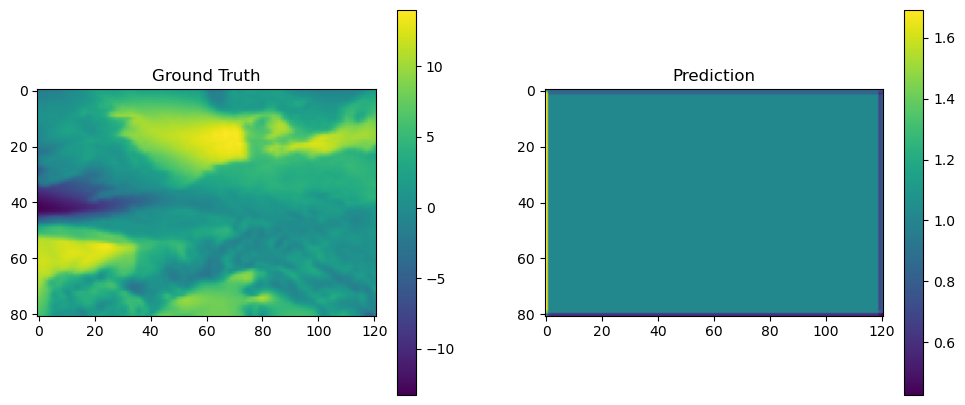

In [62]:
# -----------------------------
# Config
# -----------------------------
BATCH_SIZE = 4
MODEL_PATH = "conv_lstm_model.pth"

# -----------------------------
# Load test data
# -----------------------------
X_test = np.load("preprocessed_data/X_test.npy")  # [N, T, V, H, W]
Y_test = np.load("preprocessed_data/Y_test.npy")  # [N, V, H, W]

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

test_ds = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# Load model
# -----------------------------
input_channels = X_test.shape[2]
hidden_channels = 16
kernel_size = 3
num_layers = 1

model = ConvLSTM(input_channels, hidden_channels, kernel_size, num_layers).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# -----------------------------
# Metrics
# -----------------------------
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Evaluating"):
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)  # [N, V, H, W]
all_targets = np.concatenate(all_targets, axis=0)

V = all_targets.shape[1]  # number of variables

print("\n=== Evaluation Metrics per Variable ===")
for v in range(V):
    y_true = all_targets[:, v].flatten()
    y_pred = all_preds[:, v].flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Variable {v}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# -----------------------------
# Optional: visualize predictions for the first sample
# -----------------------------

var_idx = 0  # choose variable index
sample_idx = 0

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Ground Truth")
plt.imshow(all_targets[sample_idx, var_idx], cmap="viridis")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(all_preds[sample_idx, var_idx], cmap="viridis")
plt.colorbar()
plt.show()